# Importing Modules

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_blobs, make_moons, make_circles # modules for toy dataset
from sklearn.datasets import load_iris

### Making personal ColorMap for visualization

In [0]:
 my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"]) #Color Map for mixture of only Red, Yellow, Green
 np.random.seed(0)

# Class for Feed Forward Neural Network

In [0]:
class FeedForwardNeuralNetwork:
  def __init__(self,n_input = 2, n_output = 1, hidden_sizes = [2],init_method = 'random', activation_function = 'sigmoid', leaky_slope = 0.1):
    self.nx = n_input
    self.ny = n_output
    self.nh = len(hidden_sizes)
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {}
    self.B = {}
    self.V_W = {}
    self.V_B = {}
    self.M_W = {}
    self.M_B = {}
    
    np.random.seed(0)
    
    if init_method =='random': #Randomly Initializing weights
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i+1],self.sizes[i])
        self.V_W[i+1] = np.zeros((self.sizes[i+1],self.sizes[i]))
        self.M_W[i+1] = np.zeros((self.sizes[i+1],self.sizes[i]))
        self.B[i+1] = np.zeros((self.sizes[i+1],1))
        self.V_B[i+1] = np.zeros((self.sizes[i+1],1))
        self.M_B[i+1] = np.zeros((self.sizes[i+1],1))
        
    if init_method =='xavier': # Xavier Method of initializing weights for sigmoid and tanh activation
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i+1],self.sizes[i])*(1/np.sqrt(self.sizes[i]))
        self.V_W[i+1] = np.zeros((self.sizes[i+1],self.sizes[i]))
        self.M_W[i+1] = np.zeros((self.sizes[i+1],self.sizes[i]))
        self.B[i+1] = np.zeros((self.sizes[i+1],1))
        self.V_B[i+1] = np.zeros((self.sizes[i+1],1))
        self.M_B[i+1] = np.zeros((self.sizes[i+1],1))
        
    if init_method =='he': # He method for initializing weights for ReLU and leaky ReLU
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i+1],self.sizes[i])*(np.sqrt(2/(self.sizes[i])))
        self.V_W[i+1] = np.zeros((self.sizes[i+1],self.sizes[i]))
        self.M_W[i+1] = np.zeros((self.sizes[i+1],self.sizes[i]))
        self.B[i+1] = np.zeros((self.sizes[i+1],1))
        self.V_B[i+1] = np.zeros((self.sizes[i+1],1))
        self.M_B[i+1] = np.zeros((self.sizes[i+1],1))
     
  def sigmoid(self,X): # Function to Calculate sigmoid
    return 1.0/(1.0 + np.exp(-X))

  def softmax(self,X): # Function to calculate sigmoid of an array 
    exps = np.exp(X)
    return exps/np.sum(exps,axis=0).reshape(1,-1)
  
  def forward_activation(self, X): # Common Function to calculate forward acivation based on activation function passed as parameter
    if self.activation_function == 'sigmoid':
      return self.sigmoid(X)
    
    if self.activation_function == 'tanh':
      return np.tanh(X)
    
    if self.activation_function == 'relu':
      return np.maximum(0,X)
    
    if self.activation_function == 'leaky_relu':
      return np.maximum(self.leaky_slope*X,X)
    
    
  def backward_activation(self, X): # Common Function to calculate gradient of activation function used during backpropagation
    if self.activation_function == 'sigmoid':
      h = self.sigmoid(X)
      return h*(1-h)
    
    if self.activation_function == 'tanh':
      h = np.tanh(X)
      return (1-np.power(h,2))
    
    if self.activation_function == 'relu':
      return 1.0*(X>0)
    
    if self.activation_function == 'leaky_relu':
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
    

  def feed_forward(self,X): #Function to calculate Feed Forward - activation_function(WX+B)
    self.A = {}
    self.H = {}
    self.H[0] = X
    self.A[0] = X
    
    for i in range(self.nh):
      
      self.A[i+1] = np.matmul(self.W[i+1],self.H[i]) + self.B[i+1]

      self.H[i+1] = self.forward_activation(self.A[i+1]) 

 
    self.A[self.nh+1] = np.matmul(self.W[self.nh+1],self.H[self.nh]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    
    return self.H[self.nh+1]
  
  
  def grad_sigmoid(self,x):
    return x*(1-x)
  
  
  def grad(self, X, Y): # Function to calculate Gradient of each weight for Backpropagation
     
    self.feed_forward(X)
    
    self.dW = {}
    self.dB = {}
    
    self.dH = {}
    self.dA = {}
    
    L = self.nh + 1
    self.dA[L] = self.H[L] - Y
    
    for i in range(L,0,-1): 
      if self.l2_norm:
        self.dW[i] = np.matmul(self.dA[i],self.H[i-1].T) + self.lambda_val * self.W[i]
      else:
        self.dW[i] = np.matmul(self.dA[i],self.H[i-1].T)
      self.dB[i] = np.sum(self.dA[i], axis = 1).reshape(1,-1) 
      self.dB[i] = self.dB[i].T
      self.dH[i-1] = np.matmul(self.W[i].T,self.dA[i]) 
      self.dA[i-1] = np.multiply(self.dH[i-1],self.backward_activation(self.A[i-1])) 
    
  def fit(self, X,Y,X_val,Y_val,optimizer='vanilla', l2_norm=False,lambda_val=0.8, gamma=0.9,beta = 0.1, beta1=0.9,beta2=0.9, mini_batch_size=32,learning_rate = 1, epochs = 1,display_loss = False):
    
    self.l2_norm = l2_norm
    self.lambda_val = lambda_val
      
    if display_loss:
      loss_train = {}
      loss_val = {}
    
   
    for e in tqdm_notebook(range(epochs),total=epochs, unit = "epoch"):
      m = X.shape[1]
      
      if optimizer == 'vanilla': # using Vanilla(Original) Gradient Descent
        for k in range(0,m,mini_batch_size):
          self.grad(X[:,k:k+mini_batch_size],Y[:,k:k+mini_batch_size])

          for i in range(self.nh+1):
            
            self.W[i+1] = self.W[i+1] - (learning_rate * self.dW[i+1])/m
              
            self.B[i+1] = self.B[i+1] - (learning_rate * self.dB[i+1])/m

          if display_loss:
            Y_pred = self.predict(X)
            Y_true = np.argmax(Y,0)
            loss_train[e] = log_loss( Y_true.T,Y_pred.T)
            Y_pred = self.predict(X_val)
            Y_true = np.argmax(Y_OH_val,0)
            loss_val[e] = log_loss( Y_true.T,Y_pred.T)
            
      if optimizer == 'momentum': # Using Momentum based Gradient Descent
        for k in range(0,m,mini_batch_size):
          
          self.grad(X[:,k:k+mini_batch_size],Y[:,k:k+mini_batch_size])
          
          for i in range(self.nh+1):
            self.V_W[i+1] = gamma*self.V_W[i+1] + (learning_rate * self.dW[i+1])/m
            self.V_B[i+1] = gamma*self.V_B[i+1] + (learning_rate * self.dB[i+1])/m
            
            self.W[i+1] = self.W[i+1] - self.V_W[i+1]
            self.B[i+1] = self.B[i+1] - self.V_B[i+1]

          if display_loss:
            Y_pred = self.predict(X)
            Y_true = np.argmax(Y,0)
            loss_train[e] = log_loss( Y_true.T,Y_pred.T)
            Y_pred = self.predict(X_val)
            Y_true = np.argmax(Y_OH_val,0)
            loss_val[e] = log_loss( Y_true.T,Y_pred.T)
            
      if optimizer == 'nag': # Using Nesterov Accelerated Gradient
        for k in range(0,m,mini_batch_size):
          
          for i in range(self.nh+1):  
            self.W[i+1] = self.W[i+1] - gamma*self.V_W[i+1]
            self.B[i+1] = self.B[i+1] - gamma*self.V_B[i+1]
          
          self.grad(X[:,k:k+mini_batch_size],Y[:,k:k+mini_batch_size])
          
          for i in range(self.nh+1):
            self.W[i+1] = self.W[i+1] - (learning_rate * self.dW[i+1])/m
            self.B[i+1] = self.B[i+1] - (learning_rate * self.dB[i+1])/m
            
            self.V_W[i+1] = gamma*self.V_W[i+1] + (learning_rate * self.dW[i+1])/m
            self.V_B[i+1] = gamma*self.V_B[i+1] + (learning_rate * self.dB[i+1])/m
            
          if display_loss:
            Y_pred = self.predict(X)
            Y_true = np.argmax(Y,0)
            loss_train[e] = log_loss( Y_true.T,Y_pred.T)
            Y_pred = self.predict(X_val)
            Y_true = np.argmax(Y_OH_val,0)
            loss_val[e] = log_loss( Y_true.T,Y_pred.T)
      
      if optimizer == 'adagrad': # Using AdaGrad (Adaptive Gradient)
        for k in range(0,m,mini_batch_size):
          
          self.grad(X[:,k:k+mini_batch_size],Y[:,k:k+mini_batch_size])
          
          for i in range(self.nh+1):
            self.V_W[i+1] = self.V_W[i+1] + np.power(self.dW[i+1]/m,2)
            self.V_B[i+1] = self.V_B[i+1] + np.power(self.dB[i+1]/m,2)
            
            self.W[i+1] = self.W[i+1] - (learning_rate/(np.sqrt(self.V_W[i+1])+ 1e-8))*self.dW[i+1]/m
            self.B[i+1] = self.B[i+1] - (learning_rate/(np.sqrt(self.V_B[i+1])+ 1e-8))*self.dB[i+1]/m

          if display_loss:
            Y_pred = self.predict(X)
            Y_true = np.argmax(Y,0)
            loss_train[e] = log_loss( Y_true.T,Y_pred.T)
            Y_pred = self.predict(X_val)
            Y_true = np.argmax(Y_OH_val,0)
            loss_val[e] = log_loss( Y_true.T,Y_pred.T)
            
      if optimizer == 'rmsprop': # Using RMSProp Gradient Descent
        for k in range(0,m,mini_batch_size):
          
          self.grad(X[:,k:k+mini_batch_size],Y[:,k:k+mini_batch_size])
          
          for i in range(self.nh+1):
            self.V_W[i+1] = beta*self.V_W[i+1] + (1-beta)*np.power(self.dW[i+1]/m,2)
            self.V_B[i+1] = beta*self.V_B[i+1] + (1-beta)*np.power(self.dB[i+1]/m,2)
            
            self.W[i+1] = self.W[i+1] - (learning_rate/(np.sqrt(self.V_W[i+1])+ 1e-8))*self.dW[i+1]/m
            self.B[i+1] = self.B[i+1] - (learning_rate/(np.sqrt(self.V_B[i+1])+ 1e-8))*self.dB[i+1]/m

          if display_loss:
            Y_pred = self.predict(X)
            Y_true = np.argmax(Y,0)
            loss_train[e] = log_loss( Y_true.T,Y_pred.T)
            Y_pred = self.predict(X_val)
            Y_true = np.argmax(Y_OH_val,0)
            loss_val[e] = log_loss( Y_true.T,Y_pred.T)
        
        
      if optimizer == 'adam': # Using Adam Gradient Descent
        num_updates = 0
        for k in range(0,m,mini_batch_size):
          
          self.grad(X[:,k:k+mini_batch_size],Y[:,k:k+mini_batch_size])
          
          for i in range(self.nh+1):
            num_updates+=1
            self.M_W[i+1] = beta1*self.M_W[i+1] + (1-beta1)*self.dW[i+1]/m
            self.M_B[i+1] = beta1*self.M_B[i+1] + (1-beta1)*self.dB[i+1]/m
            
            self.V_W[i+1] = beta2*self.V_W[i+1] + (1-beta2)*np.power(self.dW[i+1]/m,2)
            self.V_B[i+1] = beta2*self.V_B[i+1] + (1-beta2)*np.power(self.dB[i+1]/m,2)
            
            self.M_W[i+1] = self.M_W[i+1]/(1-np.power(beta1,num_updates))/m
            self.M_B[i+1] = self.M_B[i+1]/(1-np.power(beta1,num_updates))/m
            
            self.V_W[i+1] = self.V_W[i+1]/(1-np.power(beta2,num_updates))/m
            self.V_B[i+1] = self.V_B[i+1]/(1-np.power(beta2,num_updates))/m
            
            
            self.W[i+1] = self.W[i+1] - (learning_rate/(np.sqrt(self.V_W[i+1])+ 1e-8))*self.M_W[i+1]
            self.B[i+1] = self.B[i+1] - (learning_rate/(np.sqrt(self.V_B[i+1])+ 1e-8))*self.M_B[i+1]

          if display_loss:
            Y_pred = self.predict(X)
            Y_true = np.argmax(Y,0)
            loss_train[e] = log_loss( Y_true.T,Y_pred.T)
            Y_pred = self.predict(X_val)
            Y_true = np.argmax(Y_val,0)
            loss_val[e] = log_loss( Y_true.T,Y_pred.T)
    
    if display_loss:
      ax = plt.subplots(figsize=(10,10))
      plt.plot(loss_train.values(),c='r',label="Training Loss")
      plt.plot(loss_val.values(),c='g',label="Validation Loss")
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.legend()
      plt.show()
      print("Loss: ",loss_train[len(loss_train)-1])
      
      
  def predict(self,X): # Function to predict the class of output
    Y_pred = self.feed_forward(X)
    return np.array(Y_pred).squeeze()
      
  def predict_h(self,X,L,i): # Function to return the values contained in i-th neuron of L-th layer
    Y_pred = self.feed_forward(X)
    return np.array(self.H[L][i]).squeeze()
    

# Preparing Toy Dataset for Demonstration

In [4]:
# Toy dataset containing 1000 entries and 4 output class with 2 input features
data,labels = make_blobs(n_samples = 1000, centers=4,n_features=2,random_state=0)


print(data.shape, labels.shape)

(1000, 2) (1000,)


In [0]:
# Standard scaling the feature

sc = StandardScaler()
data = sc.fit_transform(data)

## Visualising the dataset

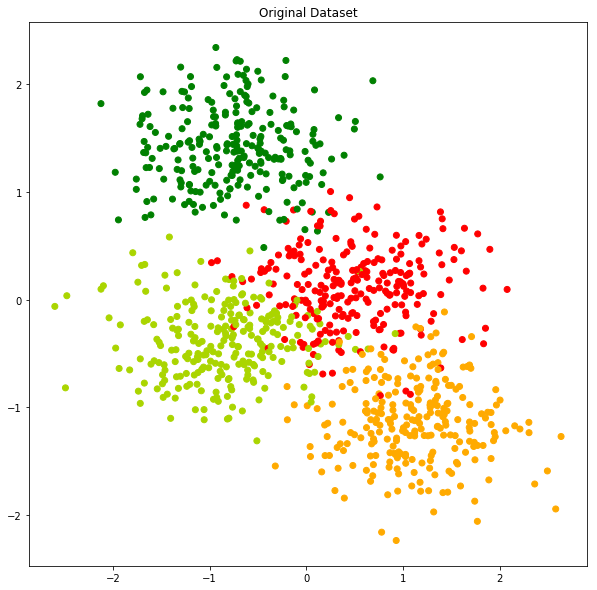

In [6]:
ax = plt.subplots(figsize=(10,10))
plt.title('Original Dataset')
plt.scatter(data[:,0],data[:,1], c = labels, cmap=my_cmap)
plt.show()

## Reshaping and preparing data for Training

In [7]:
labels_orig = labels
X = data.T
labels = labels.reshape(-1,1)
print(X.shape, labels.shape,data.shape)


(2, 1000) (1000, 1) (1000, 2)


In [8]:
# Splitting the dataset into train and validation part
X_train,X_val,Y_train,Y_val = train_test_split(data,labels_orig, stratify=labels, test_size=0.2,random_state=0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(800, 2) (200, 2) (800,) (200,)


In [9]:
X_train = X_train.T
X_val = X_val.T
Y_train =Y_train.reshape(-1,1)
Y_val =Y_val.reshape(-1,1)

print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(2, 800) (2, 200) (800, 1) (200, 1)


## One Hot Encoding the labels

In [10]:
# One hot encoding the output for Calculating Loss

ohe = OneHotEncoder(sparse = False)

Y_OH_train = ohe.fit_transform(Y_train)
Y_OH_val = ohe.fit_transform(Y_val)


Y_OH_train = Y_OH_train.T
Y_OH_val = Y_OH_val.T
print(Y_OH_train.shape,Y_OH_val.shape)



(4, 800) (4, 200)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

# Model Initialization and Training

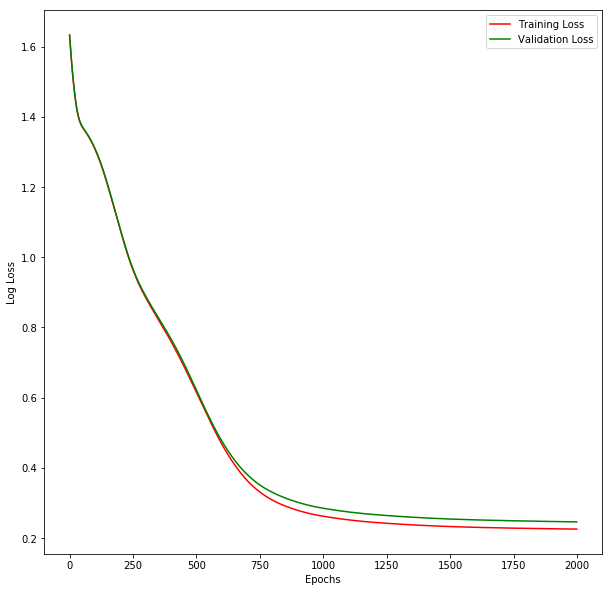

Loss:  0.2254242090261088
CPU times: user 9.79 s, sys: 214 ms, total: 10 s
Wall time: 9.79 s


In [29]:
# Initiliazing the FFNN with 2 input, 4 output, hidden layers with size 3,4 respectively, 'xavier' weight initialization method
# Sigmoid activation function
%%time
ffn = FeedForwardNeuralNetwork(n_input = 2, n_output = 4, hidden_sizes = [3,4],init_method = 'xavier', 
                               activation_function = 'sigmoid', leaky_slope = 0.01)

# Starting the training part by passing various parameters
ffn.fit(X_train,Y_OH_train,X_val,Y_OH_val,learning_rate=0.1, l2_norm=True,lambda_val=0.8,
        optimizer='adam',gamma=0.9,beta = 0.9, beta1=0.9,beta2=0.99, mini_batch_size=500,epochs = 2000, display_loss=True)

# Testing the model's accuracy on Validation Data

In [30]:
# Accuracy of Model on Validation Set

Y_pred = ffn.predict(X_val)
Y_pred = np.argmax(Y_pred.T,1)

print("Accuracy: ",accuracy_score(Y_pred,Y_val)*100,"%")

Accuracy:  94.0 %


# Visualizing the Outputs of the Neural Network

## Visualisation of output layer

In [0]:
from mpl_toolkits import mplot3d

[2, 3, 4, 4]


True

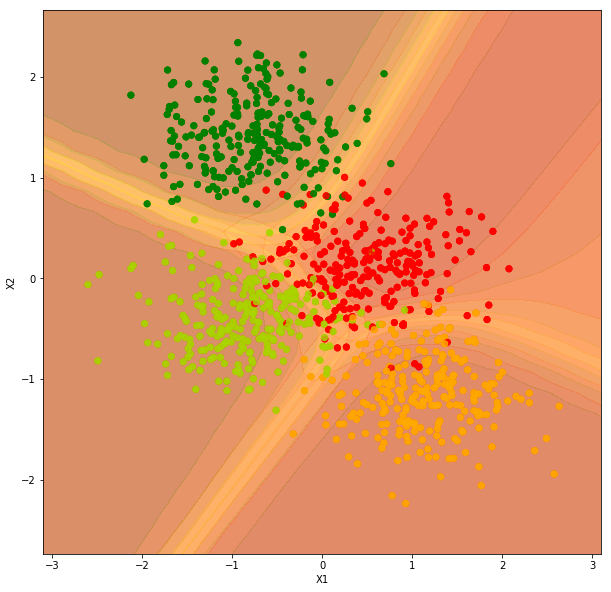

In [26]:
def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
  
def plot_contours(ax, predict, xx, yy,L,i, **params):
    Z = predict(np.c_[xx.ravel(), yy.ravel()].T,L,i)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
  
def plot_3d(ax, predict, xx, yy,L,i, **params):
    ax = plt.axes(projection = '3d')
    Z = predict(np.c_[xx.ravel(), yy.ravel()].T,L,i)
    Z = Z.reshape(xx.shape)
    out = ax.plot_surface(xx,yy,Z,**params)
    ax.scatter(X[0,:], X[1,:],0, c=labels_orig, cmap=my_cmap, alpha=0.8)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Output')
    ax.view_init(35,90)
    return out
  
def plot_boundary():
    xx, yy = make_meshgrid(X.T[:,0], X.T[:,1])
    predict_functions = [ffn.predict_h]
    sizes = ffn.sizes
    print(sizes)
    fig, ax = plt.subplots(figsize=(10,10))
    for i in range(len(sizes)-1,len(sizes)):
        for j in range(sizes[i]):
          
          plot_contours(ax, predict_functions[0], xx, yy,i,j, cmap=my_cmap, alpha=0.2)

          ax.scatter(X[0,:], X[1,:], c=labels_orig, cmap=my_cmap, alpha=0.8)
          ax.set_xlim(xx.min(), xx.max())
          ax.set_ylim(yy.min(), yy.max())
          ax.set_xlabel('X1')
          ax.set_ylabel('X2')
#     ax.set_title("H%d%d"%(i,j+1))
      
    return True
  
plot_boundary()

## Visualising output of every neuron present in the Neural Network

[2, 3, 4, 4]


True

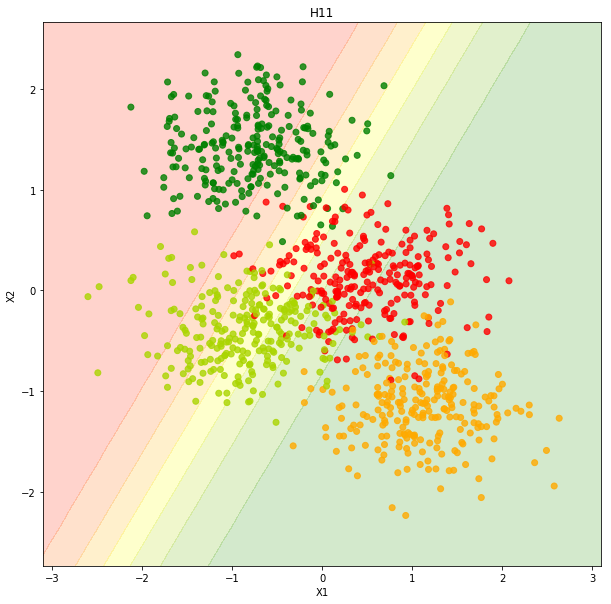

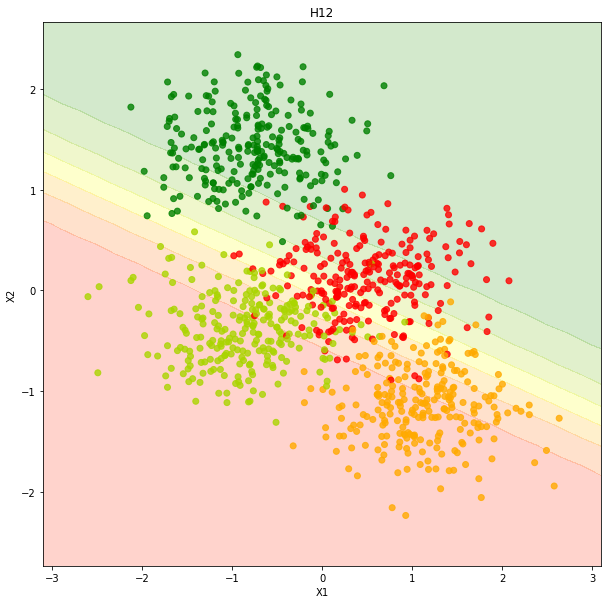

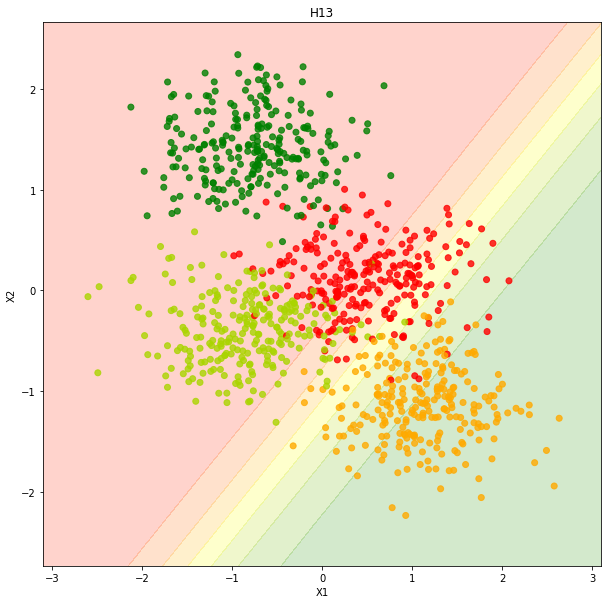

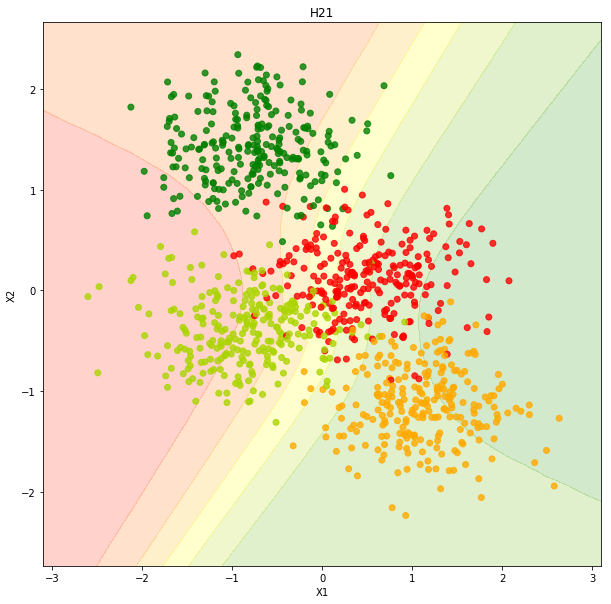

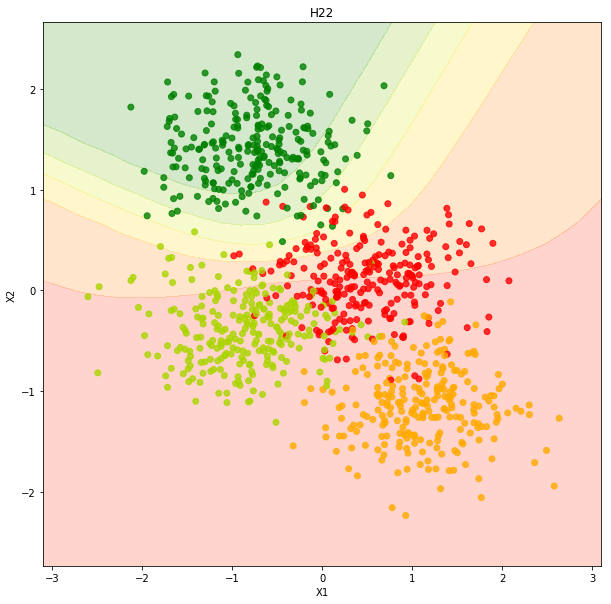

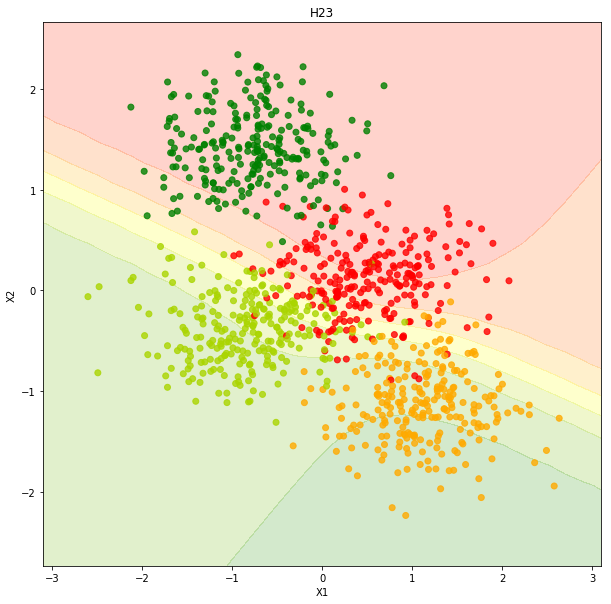

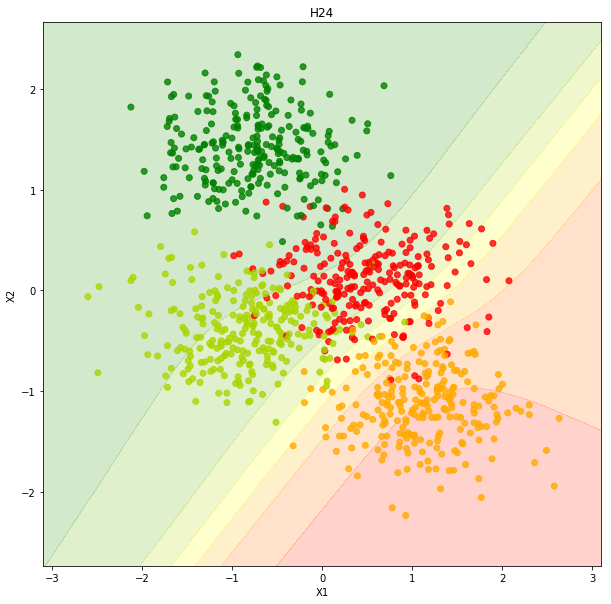

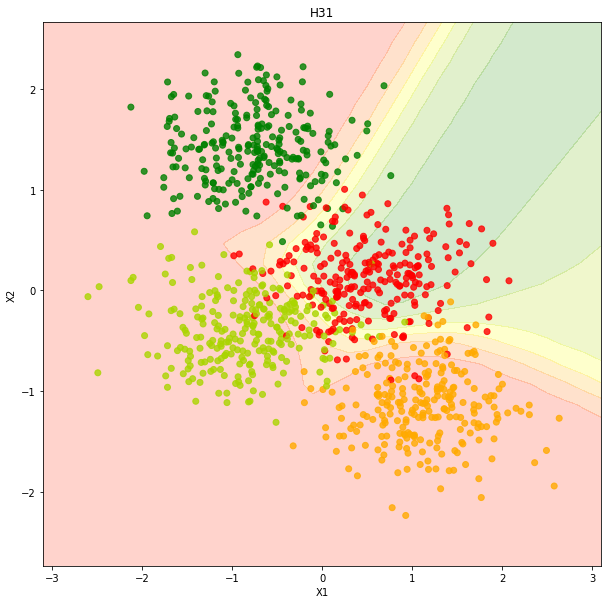

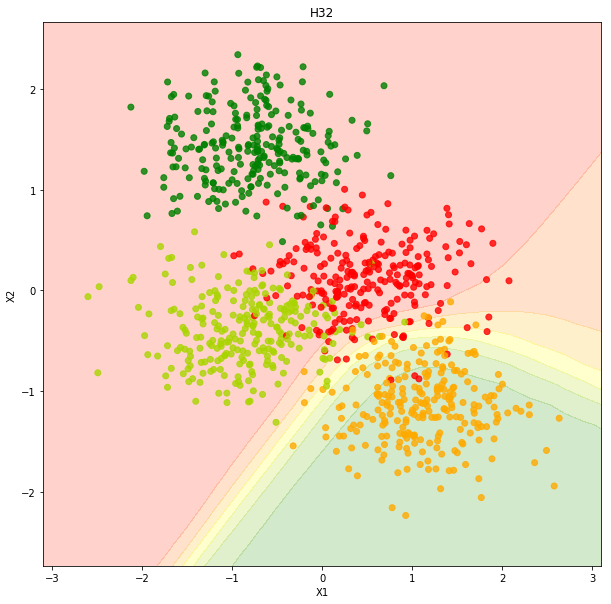

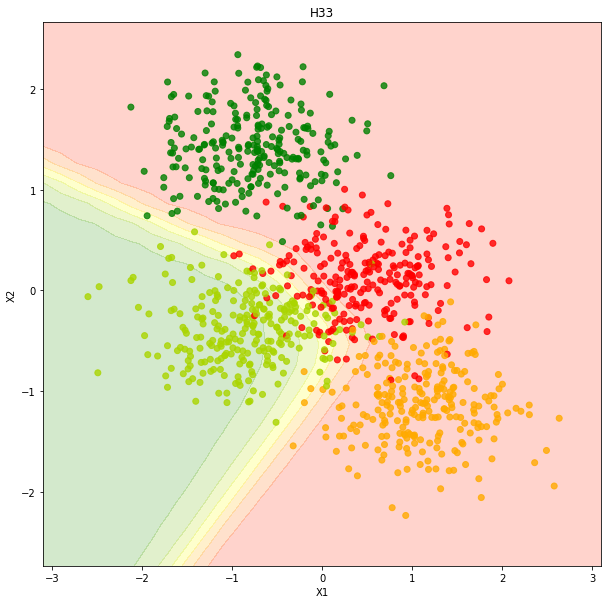

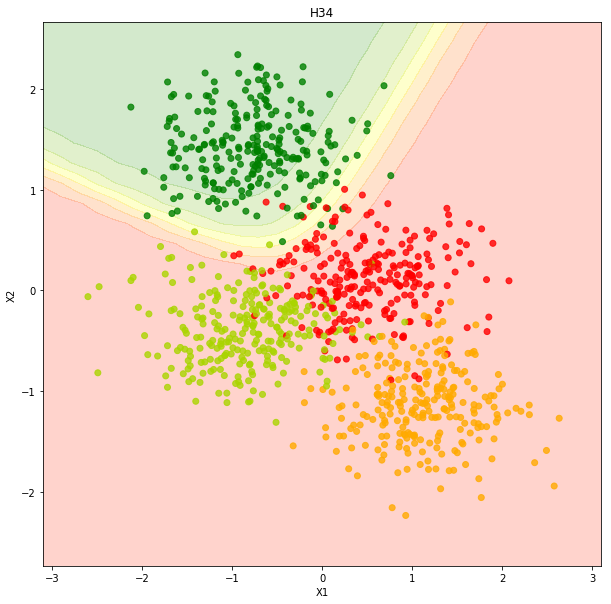

In [27]:
def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
  
def plot_contours(ax, predict, xx, yy,L,i, **params):
    Z = predict(np.c_[xx.ravel(), yy.ravel()].T,L,i)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
  
def plot_3d(ax, predict, xx, yy,L,i, **params):
    ax = plt.axes(projection = '3d')
    Z = predict(np.c_[xx.ravel(), yy.ravel()].T,L,i)
    Z = Z.reshape(xx.shape)
    out = ax.plot_surface(xx,yy,Z,**params)
    ax.scatter(X[0,:], X[1,:],0, c=labels_orig, cmap=my_cmap, alpha=0.8)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Output')
    ax.view_init(35,90)
    return out
  
def plot_boundary():
    xx, yy = make_meshgrid(X.T[:,0], X.T[:,1])
    predict_functions = [ffn.predict_h]
    sizes = ffn.sizes
    print(sizes)
    
    for i in range(1,len(sizes)):
        
        for j in range(sizes[i]):
          fig, ax = plt.subplots(figsize=(10,10))
          plot_contours(ax, predict_functions[0], xx, yy,i,j, cmap=my_cmap, alpha=0.2)

          ax.scatter(X[0,:], X[1,:], c=labels_orig, cmap=my_cmap, alpha=0.8)
          ax.set_xlim(xx.min(), xx.max())
          ax.set_ylim(yy.min(), yy.max())
          ax.set_xlabel('X1')
          ax.set_ylabel('X2')
          ax.set_title("H%d%d"%(i,j+1))
    return True
  
plot_boundary()